In [1]:
from keras import backend as K
from keras.layers import Bidirectional, Embedding, GRU, Dense, Activation, Lambda, Concatenate
from keras.layers.core import Reshape, Dropout
from keras.models import Model, Input, save_model, load_model

# Params
MAX_SEQUENCE_LENGTH = 20000
DISC_HIDDEN_SIZE_LSTM = 64
DISC_HIDDEN_SIZE_DENSE = 46
dropout = 0.2
weight_decay = 0.25
samples_per_epoch = 12000
learning_rate = 0.002

Using TensorFlow backend.


In [2]:
embeddings_layer_q = Embedding(
            input_dim=20000,
            output_dim=300,
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False)

embeddings_layer_d = Embedding(
            input_dim=20000,
            output_dim=300,
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False)

### AdamW

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import zip

from keras import backend as K
from keras.legacy import interfaces

from keras.optimizers import Optimizer


class AdamW(Optimizer):
    """AdamW optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay (L2 penalty) (default: 0.025).
        batch_size: integer >= 1. Batch size used during training.
        samples_per_epoch: integer >= 1. Number of samples (training points) per epoch.
        epochs: integer >= 1. Total number of epochs for training.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0.025,
                 batch_size=1, samples_per_epoch=1,
                 epochs=1, **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.batch_size = K.variable(batch_size, name='batch_size')
            self.samples_per_epoch = K.variable(samples_per_epoch, name='samples_per_epoch')
            self.epochs = K.variable(epochs, name='epochs')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        '''Bias corrections according to the Adam paper
        '''
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            '''Schedule multiplier eta_t = 1 for simple AdamW
            According to the AdamW paper, eta_t can be fixed, decay, or 
            also be used for warm restarts (AdamWR to come). 
            '''
            eta_t = 1.
            p_t = p - eta_t * (lr_t * m_t / (K.sqrt(v_t) + self.epsilon))
            if self.weight_decay != 0:
                '''Normalized weight decay according to the AdamW paper
                '''
                w_d = self.weight_decay * K.sqrt(self.batch_size / (self.samples_per_epoch * self.epochs))
                p_t = p_t - eta_t * (w_d * p)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.weight_decay)),
                  'batch_size': int(K.get_value(self.batch_size)),
                  'samples_per_epoch': int(K.get_value(self.samples_per_epoch)),
                  'epochs': int(K.get_value(self.epochs)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
adamw = AdamW(batch_size=8, samples_per_epoch=samples_per_epoch,
                      epochs=12000)

### Inputs 

In [5]:
reward = Input(shape=(None,), name='input_reward')
reward

<tf.Tensor 'input_reward:0' shape=(?, ?) dtype=float32>

In [6]:
important_sampling = Input(shape=(None,), name='input_imp_sampling')
important_sampling

<tf.Tensor 'input_imp_sampling:0' shape=(?, ?) dtype=float32>

### Queries Input

In [7]:
sequence_input_q = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_query')
sequence_input_q

<tf.Tensor 'input_query:0' shape=(?, 20000) dtype=int32>

In [8]:
embedded_sequences_q = embeddings_layer_q(sequence_input_q)
embeddings_layer_q

In [9]:
lstm_q_in = Bidirectional(GRU(DISC_HIDDEN_SIZE_LSTM, return_sequences=True, activation='elu', dropout=dropout, recurrent_dropout=dropout))(embedded_sequences_q)
lstm_q_in

<tf.Tensor 'bidirectional_1/concat:0' shape=(?, ?, 128) dtype=float32>

In [10]:
lstm_q_out = Bidirectional(GRU(DISC_HIDDEN_SIZE_LSTM, return_sequences=False, activation='elu', dropout=dropout, recurrent_dropout=dropout))(lstm_q_in)
lstm_q_out

<tf.Tensor 'bidirectional_2/concat:0' shape=(?, 128) dtype=float32>

### Documents Input

In [11]:
sequence_input_d = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_doc')
sequence_input_d

<tf.Tensor 'input_doc:0' shape=(?, 20000) dtype=int32>

In [12]:
embedded_sequences_d = embeddings_layer_d(sequence_input_d)
embedded_sequences_d

<tf.Tensor 'embedding_2/embedding_lookup:0' shape=(?, 20000, 300) dtype=float32>

In [13]:
lstm_d_in = Bidirectional(GRU(DISC_HIDDEN_SIZE_LSTM, return_sequences=True, activation='elu', dropout=dropout, recurrent_dropout=dropout))(embedded_sequences_d)
lstm_d_in

<tf.Tensor 'bidirectional_3/concat:0' shape=(?, ?, 128) dtype=float32>

In [14]:
lstm_d_out = Bidirectional(GRU(DISC_HIDDEN_SIZE_LSTM, return_sequences=False, activation='elu', dropout=dropout, recurrent_dropout=dropout))(lstm_d_in)
lstm_d_out

<tf.Tensor 'bidirectional_4/concat:0' shape=(?, 128) dtype=float32>

### Concatenate and then Dense Layers

In [15]:
x = Concatenate()([lstm_q_out, lstm_d_out])
x

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 256) dtype=float32>

In [16]:
x = Dropout(dropout)(x)
x

<tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 256) dtype=float32>

In [17]:
x = Dense(DISC_HIDDEN_SIZE_DENSE,
          activation='elu')(x)
x

<tf.Tensor 'dense_1/Elu:0' shape=(?, 46) dtype=float32>

In [18]:
x = Dense(1, activation='elu')(x)
x

<tf.Tensor 'dense_2/Elu:0' shape=(?, 1) dtype=float32>

In [19]:
temperature = 1.00
score = Lambda(lambda z: z / temperature, name='raw_score')(x)

In [20]:
score = Reshape([-1], name='score')(score)
score

<tf.Tensor 'score/Reshape:0' shape=(?, ?) dtype=float32>

In [21]:
prob = Activation('softmax', name='prob')(score)

In [22]:
model = Model(inputs=[sequence_input_q, sequence_input_d, reward, important_sampling], outputs=[prob])
model

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_query (InputLayer)        (None, 20000)        0                                            
__________________________________________________________________________________________________
input_doc (InputLayer)          (None, 20000)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20000, 300)   6000000     input_query[0][0]                
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20000, 300)   6000000     input_doc[0][0]                  
__________________________________________________________________________________________________
bidirectio

In [24]:
def __loss(_reward, _important_sampling):
    def _loss(y_true, y_pred):
        log_action_prob = K.log(y_pred)
        loss = - K.reshape(log_action_prob, [-1]) * K.reshape(_reward, [-1]) * K.reshape(_important_sampling, [-1])
        loss = K.mean(loss)
        return loss

    return _loss

In [25]:
model.compile(loss=__loss(reward, important_sampling),
                optimizer=adamw,
                metrics=['accuracy'])
model

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='generator.png')

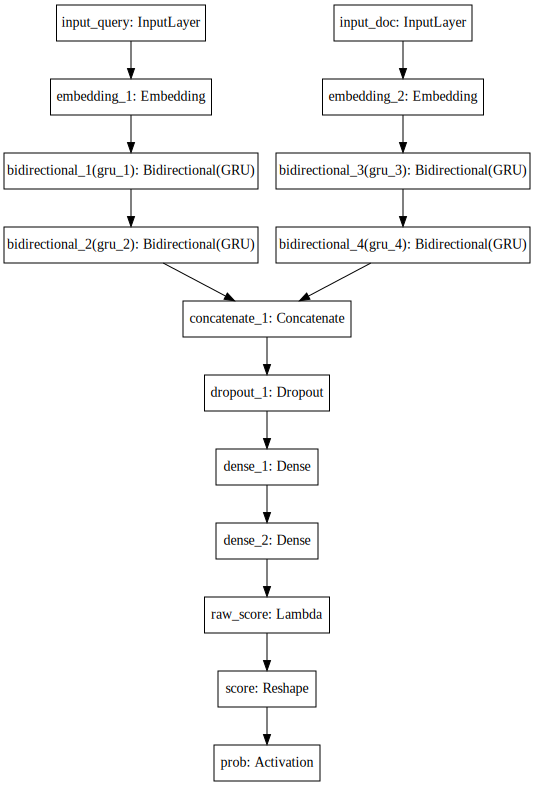

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [66]:
inp = model.inputs[:2]
print(inp)
out_score = model.get_layer("score").output
print(out_score)
out_prob = model.get_layer("prob").output
print(out_prob)

[<tf.Tensor 'input_query_1:0' shape=(?, 20000) dtype=int32>, <tf.Tensor 'input_doc_1:0' shape=(?, 20000) dtype=int32>]
Tensor("score_1/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("prob_1/Softmax:0", shape=(?, ?), dtype=float32)


In [67]:
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 20000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

WORKDIR = '/home/lukas/git-projects/lstm-irgan'
DOCUMENTS_DIR = WORKDIR + '/data/wikiclir/dev.docs'  #'/data/example/documents/'
QUERIES = WORKDIR + '/data/wikiclir/dev.queries' #'/data/example/queries.txt'
LABELLED_DATA = WORKDIR + '/data/wikiclir/dev.qrel' #'/data/example/labelled_data.txt'

def __get_documents():
    path = DOCUMENTS_DIR
    documents = {}
    doc_ids = []

    with open(path) as f:
        content = f.readlines()
        for line in content[:100]:
            values = line.split("\t", 1)
            id = int(values[0])
            text = values[1]
            documents[id] = text
            doc_ids.append(id)
    return documents, doc_ids


def __get_queries():
    path = QUERIES
    queries = {}
    query_ids = []

    with open(path) as f:
        content = f.readlines()
        for line in content[:100]:
            values = line.split("\t", 1)
            id = int(values[0])
            text = values[1]
            queries[id] = text
            query_ids.append(id)
    return queries, query_ids


def __get_ratings():
    path = LABELLED_DATA
    ratings = {}

    with open(path) as f:
        content = f.readlines()
        for line in content[:100]:
            values = line.split("\t")
            query = int(values[0])
            text = int(values[2])
            rating = float(values[3])

            if query in ratings.keys():
                ratings[query][text] = rating
            else:
                ratings[query] = {text: rating}

    return ratings


def __filter_stop_words(texts, stop_words):
    for i, text in enumerate(texts):
        new_text = [word for word in text.split() if word not in stop_words]
        texts[i] = ' '.join(new_text)
    return texts


def __init_tokenizer(text_data, max_sequence_length):
    texts = list(text_data.values())
    ids = list(text_data.keys())

    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
    texts = __filter_stop_words(texts, stop_words)

    # finally, vectorize the text samples into a 2D integer tensor
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=max_sequence_length)

    text_data_sequenced = {}
    for i, text in enumerate(data):
        text_data_sequenced[ids[i]] = text

    return tokenizer, text_data_sequenced


def get_data():
    documents_data, doc_ids = __get_documents()
    queries_data, query_ids = __get_queries()
    ratings_data = __get_ratings()

    print('Tokenize queries')
    tokenizer_q, queries_data = __init_tokenizer(queries_data, MAX_SEQUENCE_LENGTH)
    print('Tokenize documents')
    tokenizer_d, documents_data = __init_tokenizer(documents_data, MAX_SEQUENCE_LENGTH)

    print('Found %s training data.' % len(ratings_data))

    return query_ids, ratings_data, documents_data, queries_data, tokenizer_q, tokenizer_d

query_ids, ratings_data, documents_data, queries_data, tokenizer_q, tokenizer_d = get_data()

Tokenize queries
[nltk_data] Downloading package stopwords to /home/lukas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Found 1247 unique tokens.
Tokenize documents
[nltk_data] Downloading package stopwords to /home/lukas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Found 7709 unique tokens.
Found 1 training data.


In [68]:
docs = [value for key, value in list(documents_data.items())[:3]]
key, value = list(queries_data.items())[0]
queries = [value]*3
print(docs)
print(queries)

[array([   0,    0,    0, ...,   23, 3388, 1496], dtype=int32), array([   0,    0,    0, ...,  286,  591, 2098], dtype=int32), array([  0,   0,   0, ..., 169, 503, 188], dtype=int32)]
[array([  0,   0,   0, ...,   2, 204,  28], dtype=int32), array([  0,   0,   0, ...,   2, 204,  28], dtype=int32), array([  0,   0,   0, ...,   2, 204,  28], dtype=int32)]


In [70]:
def get_score(train_data_queries, train_data_documents,):
    inputs = model.inputs + [K.learning_phase()]
    out = model.get_layer('score').output
    functor = K.function(inputs, [out])
    layer_outs = functor([train_data_queries, train_data_documents, 0.])
    return layer_outs

reward = get_score(queries, docs)
reward

[array([[0.00322543],
        [0.00568766],
        [0.00801787]], dtype=float32)]

In [71]:
def get_prob(train_data_queries, train_data_documents,):
    inputs = model.inputs + [K.learning_phase()]
    out = model.get_layer('prob').output
    functor = K.function(inputs, [out])
    layer_outs = functor([train_data_queries, train_data_documents, 0.])
    return layer_outs

prob = get_prob(queries, docs)
prob

[array([[1.],
        [1.],
        [1.]], dtype=float32)]

In [ ]:
import numpy as np

def train(train_data_queries, train_data_documents, reward, important_sampling):
    model.train_on_batch([train_data_queries, train_data_documents, reward, important_sampling], np.zeros([train_data_queries.shape[0]]))

# choose data
choose_queries = np.array(queries)
choose_documents = np.array(docs)

choose_queries = np.asarray(choose_queries)
choose_documents = np.asarray(choose_documents)

choose_reward = np.asarray([0.2, 0.5, 0.6])

choose_is = np.asarray([0.2, 0.5, 0.6])

train(choose_queries, choose_documents, choose_reward.reshape([-1]), choose_is)